In [0]:
#importing the required packages
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
con = sqlite3.connect('./database.sqlite') #connecting with the sql
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 because 3 can be cosidered as a neutral
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
import datetime
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#deduplication
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#Helpfulness numerator is always less than or equal to the helpfulness denominator so we have to remove it
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
final_p = final[final.Score == 'positive']
final_p = final_p.sample(frac=0.046,random_state=1) 
final_p.shape

(14125, 10)

In [0]:
final_n = final[final.Score == 'negative']
final_n = final_n.sample(frac=0.282,random_state=1)
final_n.shape

(16105, 10)

In [0]:
final=pd.concat([final_p,final_n])
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.shape

(30230, 10)

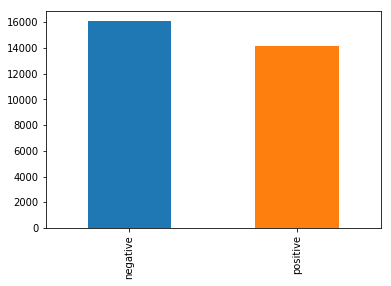

In [0]:
final['Score'].value_counts().plot(kind='bar')

# TEXT PREPROCESSING

In [0]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'re', 'which', "hadn't", "don't", 'between', 'or', 'down', "doesn't", 'be', 'aren', 'both', "should've", 'because', "wouldn't", "aren't", 'some', "you're", 'me', "mightn't", 'that', "isn't", "it's", 'few', 't', 'will', 'weren', 'most', 'herself', 'am', 'not', 'just', 'wouldn', 'what', 'who', 'under', "didn't", 'had', 'during', 'the', 'other', 'being', 'their', "that'll", 'do', 'by', 'theirs', 'when', 'and', 'of', 'only', 've', 'did', 'own', 'against', 'mightn', 'doing', "couldn't", 'more', "you've", 'ours', 'yourselves', 'whom', 'he', 'ourselves', 'each', 'o', 'over', 'wasn', 's', 'been', 'won', 'you', 'hers', 'they', 'shan', 'was', 'for', 'i', 'there', 'in', 'yours', "you'd", 'yourself', 'is', 'doesn', 'but', 'while', 'at', 'up', 'again', 'an', 'were', 'after', 'so', 'further', 'itself', 'mustn', 'our', "shan't", "weren't", 'where', 'ma', 'these', 'have', 'from', 'her', 'themselves', 'nor', 'hadn', 'him', 'then', 'this', "haven't", 'haven', "wasn't", 'are', 'needn', 'himself', 'y', '

In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string
final=final.reset_index(drop=True)
final_train=final['CleanedText']    

# KNN with BAG OF WORDS

In [0]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X = final_train
y = final['Score']
#Splitting the data for train and Test
X_train =  final_train[:math.ceil(len(final)*.7)] 
X_test = final_train[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
#Splitting the training data to train set and cross validation set
from sklearn import cross_validation
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.20)

In [0]:
count_vect = CountVectorizer() 
X_cv=count_vect.fit_transform(X_cv).toarray()
X_cv.shape

(4233, 9047)

In [0]:
from sklearn import preprocessing
final_counts=preprocessing.scale(X_cv,with_mean=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [0]:
X_cv=final_counts

In [0]:
X_cv.shape

(4233, 9047)

In [0]:
from sklearn import cross_validation
# creating odd list of K for KNN
myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation


for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=4)
    scores = cross_val_score(knn, X_cv, y_cv, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 1.


the misclassification error for each k value is :  [0.422 0.441 0.456 0.465 0.477 0.483 0.489 0.49  0.495 0.496 0.496 0.492
 0.49  0.486 0.479 0.469 0.466 0.456 0.452 0.451 0.451 0.455 0.464 0.472
 0.475]


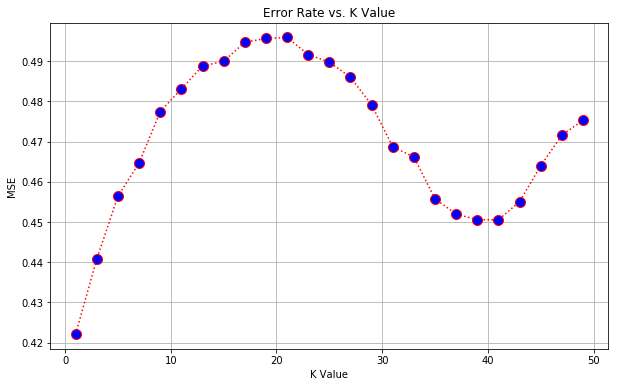

In [0]:
plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.grid()
print("the misclassification error for each k value is : ", np.round(MSE,3))

In [0]:
count_vec1=CountVectorizer()
final_x=count_vec1.fit_transform(X_train).toarray()

In [0]:
final_x.shape

(21161, 18700)

In [0]:
from sklearn import preprocessing
final_counts=preprocessing.scale(final_x,with_mean=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [0]:
X_test1=count_vec1.transform(X_test).toarray()

In [0]:
from sklearn.metrics import accuracy_score   
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1)#initializing KNeighborsClassifier to the varible knn
knn.fit(final_counts,y_train)#applying fit method to our training set
pred = knn.predict(X_test1)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)#calculating accuracy
print('\n****Test accuracy for k =3 is %d%%' % (acc))


****Test accuracy for k =3 is 52%


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


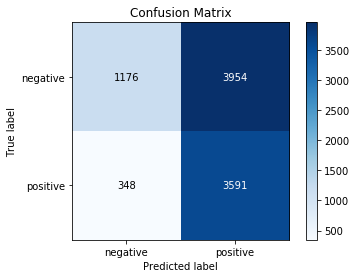

In [0]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [0]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.77      0.23      0.35      5130
   positive       0.48      0.91      0.63      3939

avg / total       0.64      0.53      0.47      9069



# KNN WITH AVERAGE WORD2VEC

In [0]:
#Splitting data into train and test
X = final
y = final['Score']
X_train =  final[:math.ceil(len(final)*.7)] 
X_test = final[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
# Training Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_model.wv.most_similar("good")

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('great', 0.8331899642944336),
 ('fine', 0.7523993253707886),
 ('bad', 0.7176321744918823),
 ('wonderful', 0.7137500047683716),
 ('decent', 0.7121127843856812),
 ('fantastic', 0.7028806209564209),
 ('amazing', 0.6789331436157227),
 ('terrible', 0.6758700013160706),
 ('ok', 0.6660566329956055),
 ('delicious', 0.6606482863426208)]

In [0]:
sent_vectors = []
for sent in X_train['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


21161
50


In [0]:
sent_vectors=pd.DataFrame(sent_vectors)
sent_vectors= sent_vectors.fillna(sent_vectors.median(axis=0))

In [0]:
from sklearn import preprocessing
sent_vectors=preprocessing.scale(sent_vectors,with_mean=False)

In [0]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=4)
    scores = cross_val_score(knn,sent_vectors,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 45.


the misclassification error for each k value is :  [0.487 0.474 0.47  0.47  0.469 0.467 0.466 0.463 0.459 0.46  0.458 0.456
 0.459 0.458 0.458 0.456 0.455 0.454 0.452 0.452 0.449 0.449 0.448 0.448
 0.449]


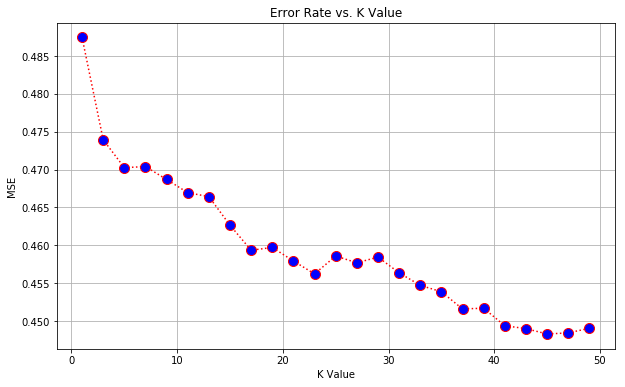

In [0]:
plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.grid()
print("the misclassification error for each k value is : ", np.round(MSE,3))    

In [0]:
import gensim
i=0
list_of_sent=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [0]:
import gensim
w2v_model1=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
sent_vectors1 = []
for sent in X_test['Text'].values: # for each review/sentence in test
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        
        try:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


9069
50


In [0]:
test=pd.DataFrame(sent_vectors1)
test= test.fillna(test.median(axis=0)) 

In [0]:
from sklearn import preprocessing
test=preprocessing.scale(test,with_mean=False)

In [0]:
from sklearn.metrics import accuracy_score   
knn = KNeighborsClassifier(n_neighbors=optimal_k)#initializing KNeighborsClassifier to the varible knn
knn.fit(sent_vectors,y_train)#applying fit method to our training set
pred = knn.predict(test)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


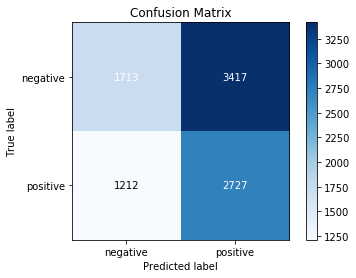

In [0]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [0]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.59      0.33      0.43      5130
   positive       0.44      0.69      0.54      3939

avg / total       0.52      0.49      0.48      9069



In [0]:
print("Accuracy for KNN model with Average Word2Vec is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Average Word2Vec is  0.49


# KNN with TF-IDF

In [0]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_train
y = final['Score']

X_train =  final_train[:math.ceil(len(final)*.7)] 
X_test = final_train[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
#Splitting the training data to train set and cross validation set
from sklearn import cross_validation
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.30)

In [0]:
#vectorizing the cross validation to find the optimal K value
tf_idf_vect = TfidfVectorizer()# It will create unigram as well as bigram
final_tf_idf = tf_idf_vect.fit_transform(X_cv.values)

In [0]:
 # creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=4)
    scores = cross_val_score(knn, final_tf_idf, y_cv, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 49.


the misclassification error for each k value is :  [0.367 0.335 0.33  0.31  0.303 0.291 0.288 0.285 0.278 0.279 0.273 0.267
 0.262 0.257 0.257 0.256 0.246 0.248 0.244 0.244 0.245 0.243 0.243 0.243
 0.237]


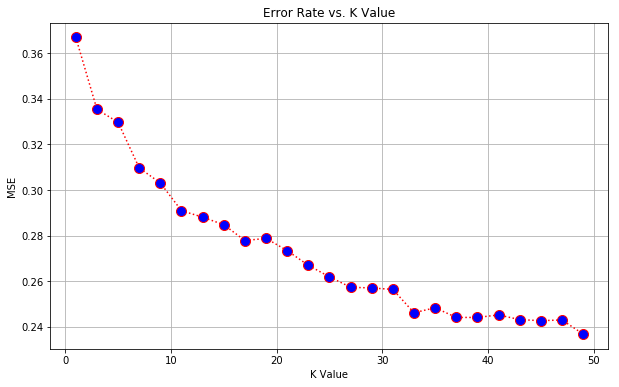

In [0]:
plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.grid()
print("the misclassification error for each k value is : ", np.round(MSE,3))
    

In [0]:
#now we will take our training set and vectorize it using TF-IDF to feed it into knn Model
tf_idf_vect1 = TfidfVectorizer()# It will create unigram as well as bigram
final_tf_idf1 = tf_idf_vect1.fit_transform(X_train.values)
final_tf_idf1.shape

(21161, 18700)

In [0]:
from sklearn import preprocessing
final_tf_idf1=preprocessing.scale(final_tf_idf1,with_mean=False)

In [0]:
tf_idf_test=tf_idf_vect1.transform(X_test.values)

In [0]:
from sklearn.metrics import accuracy_score   
knn = KNeighborsClassifier(n_neighbors=optimal_k)#initializing KNeighborsClassifier to the varible knn
knn.fit(final_tf_idf1,y_train)#applying fit method to our training set
pred = knn.predict(tf_idf_test)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


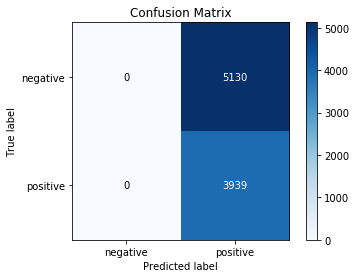

In [0]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [0]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      5130
   positive       0.43      1.00      0.61      3939

avg / total       0.19      0.43      0.26      9069



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print("Accuracy for KNN model with TF-IDF is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Average Word2Vec is  0.434


# KNN with TF-IDF WORD2VEC

In [0]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X = final
y = final['Score']
X_train =  final[:math.ceil(len(final)*.7)] 
X_test = final[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
tf_idf_vector = TfidfVectorizer()# It will create unigram as well as bigram
final_tf_idf = tf_idf_vector.fit_transform(X_train['Text'].values)

In [0]:
final_tf_idf.shape

(21161, 30052)

In [0]:
import gensim
i=0
list_of_sent=[]
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [0]:
import gensim
w2v_model_1=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vector.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_train['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        try:
            vec = w2v_model_1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (tf_idf*vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [0]:
tfidf_sent_vectors=pd.DataFrame(tfidf_sent_vectors)
tfidf_sent_vectors= tfidf_sent_vectors.fillna(tfidf_sent_vectors.median(axis=0))

In [0]:
 # creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=4)
    scores = cross_val_score(knn, tfidf_sent_vectors, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 49.


the misclassification error for each k value is :  [0.352 0.321 0.309 0.299 0.295 0.29  0.286 0.285 0.282 0.283 0.278 0.278
 0.277 0.278 0.276 0.275 0.277 0.277 0.276 0.276 0.275 0.277 0.276 0.276
 0.275]


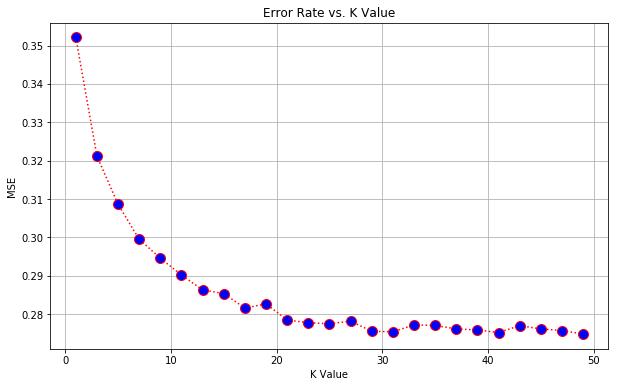

In [0]:
plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.grid()
print("the misclassification error for each k value is : ", np.round(MSE,3))

In [0]:
#now we will take our training set and vectorize it using TF-IDF to feed it into knn Model
final_tf_idf2 = tf_idf_vector.transform(X_test['Text'].values)
final_tf_idf2.shape

(9069, 30052)

In [0]:
import gensim
i=0
list_of_sent=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [0]:
import gensim
w2v_model_2=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = tf_idf_vector.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_test['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        try:
            vec = w2v_model_2.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat_1.index(word)]
            sent_vec += (tf_idf*vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [0]:
tfidf_sent_vectors1=pd.DataFrame(tfidf_sent_vectors1)
tfidf_sent_vectors1= tfidf_sent_vectors1.fillna(tfidf_sent_vectors.median(axis=0))

In [0]:
from sklearn import preprocessing
tfidf_sent_vectors1=preprocessing.scale(tfidf_sent_vectors1,with_mean=False)

In [0]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1)#initializing KNeighborsClassifier to the varible knn
knn.fit(tfidf_sent_vectors, y_train)#applying fit method to our training set
pred = knn.predict(tfidf_sent_vectors1)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


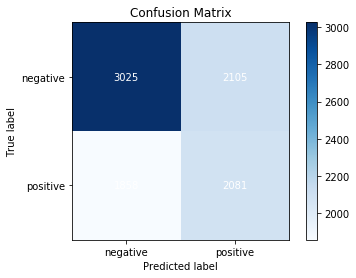

In [0]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [0]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.62      0.59      0.60      5130
   positive       0.50      0.53      0.51      3939

avg / total       0.57      0.56      0.56      9069



In [0]:
print("Accuracy for KNN model with TF-IDF W2V is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with TF-IDF W2V is  0.563


## Accuracy measure with various vectorization technique:-
##### 1. With BAG of WORDS it is 53.00%
##### 2. With Avg. Word2Vec it is 49.00%
##### 3. With TF-IDF it is 43.4%
##### 4. With TF-IDF Word2Vec it is 56.3%

# Conclusion:-
### Amongst all thevectorization technique our TF-IDF Word2Vec gives highest accuracy score .